In [1]:
import os
os.chdir('/Users/zhanwenxin/Documents/GitHub/cuTAGI')

import scipy.io as sio
from scipy.stats import norm
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import gridspec
from src.RL_functions.generate_one_synthetic_time_series import generate_one_synthetic_time_series
from src.RL_functions.kalman_filter import KalmanFilter

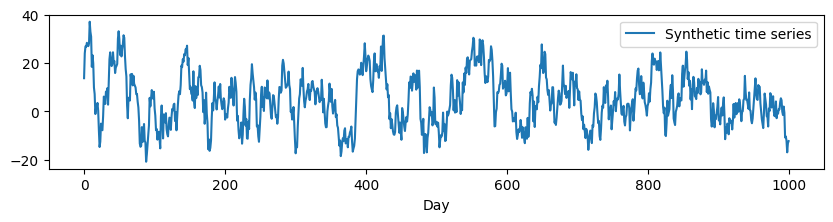

In [2]:
# Generate synthetic data
# components = ['level','fourrier','ar']
components = ['level','ar']
time_step_interval = 1

AR_param_var = 5**2
AR_param_phi = 0.9
hyperparameters = {'level': {'process_error_var': 0.0},
                #    'fourrier': {'period': 52, 'process_error_var': 0},
                   'ar': {'phi': AR_param_phi, 'process_error_var': AR_param_var},
                   'observation': {'error': 1e-6}}
x_init = {'mu': np.array([5, -0.0621]), \
          'var': np.diag([0.00531, 6.36E-05])}
# x_init = {'mu': np.array([5, np.sqrt(AR_param_var) * 5, 0, -0.0621]), \
#           'var': np.diag([0.00531,1e-12, 1e-12, 6.36E-05])}
num_steps = 1000

AR_stationary_var = hyperparameters['ar']['process_error_var'] / (1 - hyperparameters['ar']['phi']**2)

# Set seed
np.random.seed(0)

data_generator = generate_one_synthetic_time_series(components = components, 
                                                    time_step_interval = time_step_interval, 
                                                    hyperparameters = hyperparameters, 
                                                    num_steps = num_steps,
                                                    x_init = x_init)

# # ts = data_generator.generate_time_series()
data_generator.plot()

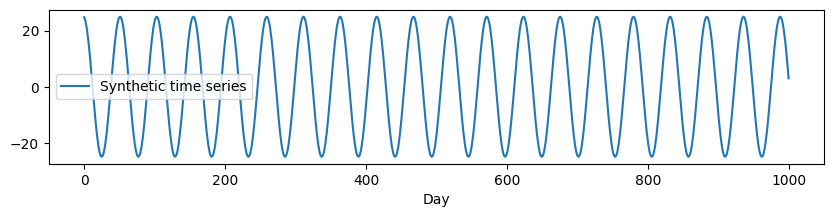

In [3]:
# Generate periodic pattern
components_P = ['level','fourrier']

hyperparameters_P = {'level': {'process_error_var': 0.0},
                   'fourrier': {'period': 52, 'process_error_var': 0},
                   'observation': {'error': 0}}
x_init_P = {'mu': np.array([0, np.sqrt(AR_param_var) * 5, 0]), \
          'var': np.diag([0,1e-12, 1e-12])}

data_generator_P = generate_one_synthetic_time_series(components = components_P, 
                                                    time_step_interval = time_step_interval, 
                                                    hyperparameters = hyperparameters_P, 
                                                    num_steps = num_steps,
                                                    x_init = x_init_P)

# # ts = data_generator.generate_time_series()
data_generator_P.plot()

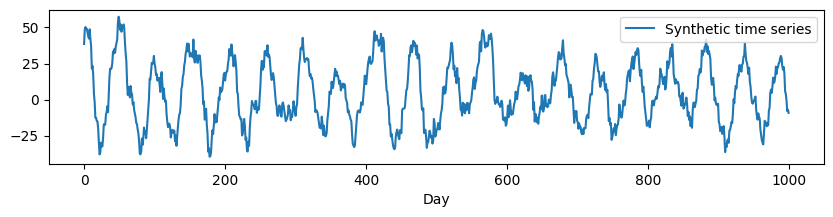

In [4]:
# Add periodic patten
data_generator.time_series['y'] = (np.array(data_generator.time_series['y']) + np.array(data_generator_P.time_series['y'])).tolist()

data_generator.plot()

In [5]:
######################################## Base model ########################################
components = ['trend','fourrier', 'ar']
# components = ['trend', 'ar']

hyperparameters = {'trend': {'process_error_var': 0},
                   'fourrier': {'period': 52, 'process_error_var': 0},
                   'ar': {'phi': AR_param_phi, 'process_error_var': AR_param_var},
                   'observation': {'error': 1e-6}}
# x_init = {'mu': np.array([5, 0.0, -0.0621]), \
#           'var': np.diag([1e-12, 1E-12, 6.36E-05])}
x_init = {'mu': np.array([5, 0.0,np.sqrt(AR_param_var) * 5, 0, -0.0621]), \
          'var': np.diag([1e-12, 1E-12,1e-12, 1E-12, 6.36E-05])}

kf = KalmanFilter(components = components, time_step=time_step_interval, hyperparameters = hyperparameters)

######################################## Meta-AR model ########################################
components_d = ['trend', 'ar']

# expected_detection_time = 52 * 3
baseline_process_error_var = AR_stationary_var / 1e7

hyperparameters_d = {'trend': {'process_error_var': baseline_process_error_var, 'phi': 1},
                   'ar': {'phi': AR_param_phi, 'process_error_var': AR_param_var},
                   'observation': {'error': 1e-6}}
x_init_d = {'mu': np.array([0, 0.0, -0.0621]), \
          'var': np.diag([1e-12, 1e-12, 6.36E-05])}

kf_d = KalmanFilter(components = components_d, time_step=time_step_interval, hyperparameters = hyperparameters_d)

# Anomaly settings
anm_pos = 400
# anm_mag = -2 * (np.sqrt(AR_stationary_var)*1) / 50
anm_mag = - (np.sqrt(AR_stationary_var)*1) / 50
# anm_mag = 0

# Trigger settings
# Randomly generate 500 numbers between 0 and 1000
# trigger_pos = np.random.randint(0, 1000, 500).tolist()
# trigger_pos = [500, 600]
trigger_pos = [550]


In [6]:
############## Run two models ################
x_last_step = x_init
x_last_step_d = x_init_d
LL_mu, LT_mu, AR_mu = [], [], []
LL_var, LT_var, AR_var = [], [], []
LLd_mu, LTd_mu, ARd_mu = [], [], []
LLd_var, LTd_var, ARd_var = [], [], []
y_pred_mus, y_pred_vars = [], []
y_pred_mus_d, y_pred_vars_d = [], []
total_reward = 0
rewards = []
LT_reference = None
for i in range(num_steps):
    # Add anomaly 
    if i >= anm_pos:
        data_generator.time_series['y'][i] += anm_mag * (i - anm_pos)
        # data_generator.time_series['y'][i] += anm_mag

    
    ############ Base model ############
    if i+1 in trigger_pos:
        LT_reference = x_last_step['mu'][1]

        # Assign the drrift hidden states to the base ones
        x_last_step['mu'][0] += x_last_step_d['mu'][0]
        x_last_step['mu'][1] += x_last_step_d['mu'][1]
        x_last_step['var'][0,0] += x_last_step_d['var'][0,0]
        x_last_step['var'][1,1] += x_last_step_d['var'][1,1]
        # x_last_step['var'][1,1] += 0.01
        x_last_step['mu'][-1] = x_last_step_d['mu'][-1]
        x_last_step['var'][-1,-1] = x_last_step_d['var'][-1,-1]
        x_last_step_d = x_init_d

    y_pred, x_pred, _ = kf.predict(x_last_step)
    x_updated, likelihood, _ = kf.update(data_generator.time_series['y'][i])

    # Define reward
    reward = np.log(likelihood)

    # Penalties
    if LT_reference is not None:
        reward -= 1 * norm.pdf(LT_reference, loc=x_last_step['mu'][1], scale=np.sqrt(x_last_step['var'][1,1])) \
                        /norm.pdf(x_last_step['mu'][1], loc=x_last_step['mu'][1], scale=np.sqrt(x_last_step['var'][1,1]))

    rewards.append(reward)

    ############ Meta-AR model ############
    pred_AR, xd_pred, _ = kf_d.predict(x_last_step_d)
    pred_AR['mu'] = pred_AR['mu'].item()
    pred_AR['var'] = pred_AR['var'].item()

    # Smoother equations to update
    target_AR = {'mu': x_pred['mu'][-1], 'var': x_pred['var'][-1,-1]}
    cov_x_AR = xd_pred['var'] @ kf_d.F.T
    xd_updated = kf_d.dist_update(target_AR, pred_AR, xd_pred, cov_x_AR)

    x_last_step = x_updated
    x_last_step_d = xd_updated

    LL_mu.append(x_pred['mu'][0])
    LT_mu.append(x_pred['mu'][1])
    AR_mu.append(x_pred['mu'][-1])
    LL_var.append(x_pred['var'][0,0])
    LT_var.append(x_pred['var'][1,1])
    AR_var.append(x_pred['var'][-1,-1])
    y_pred_mus.append(y_pred['mu'].item())
    y_pred_vars.append(y_pred['var'].item())

    LLd_mu.append(xd_pred['mu'][0])
    LTd_mu.append(xd_pred['mu'][1])
    ARd_mu.append(xd_pred['mu'][-1])
    LLd_var.append(xd_pred['var'][0,0])
    LTd_var.append(xd_pred['var'][1,1])
    ARd_var.append(xd_pred['var'][-1,-1])
    y_pred_mus_d.append(pred_AR['mu'])
    y_pred_vars_d.append(pred_AR['var'])


Text(0, 0.5, 'ARd')

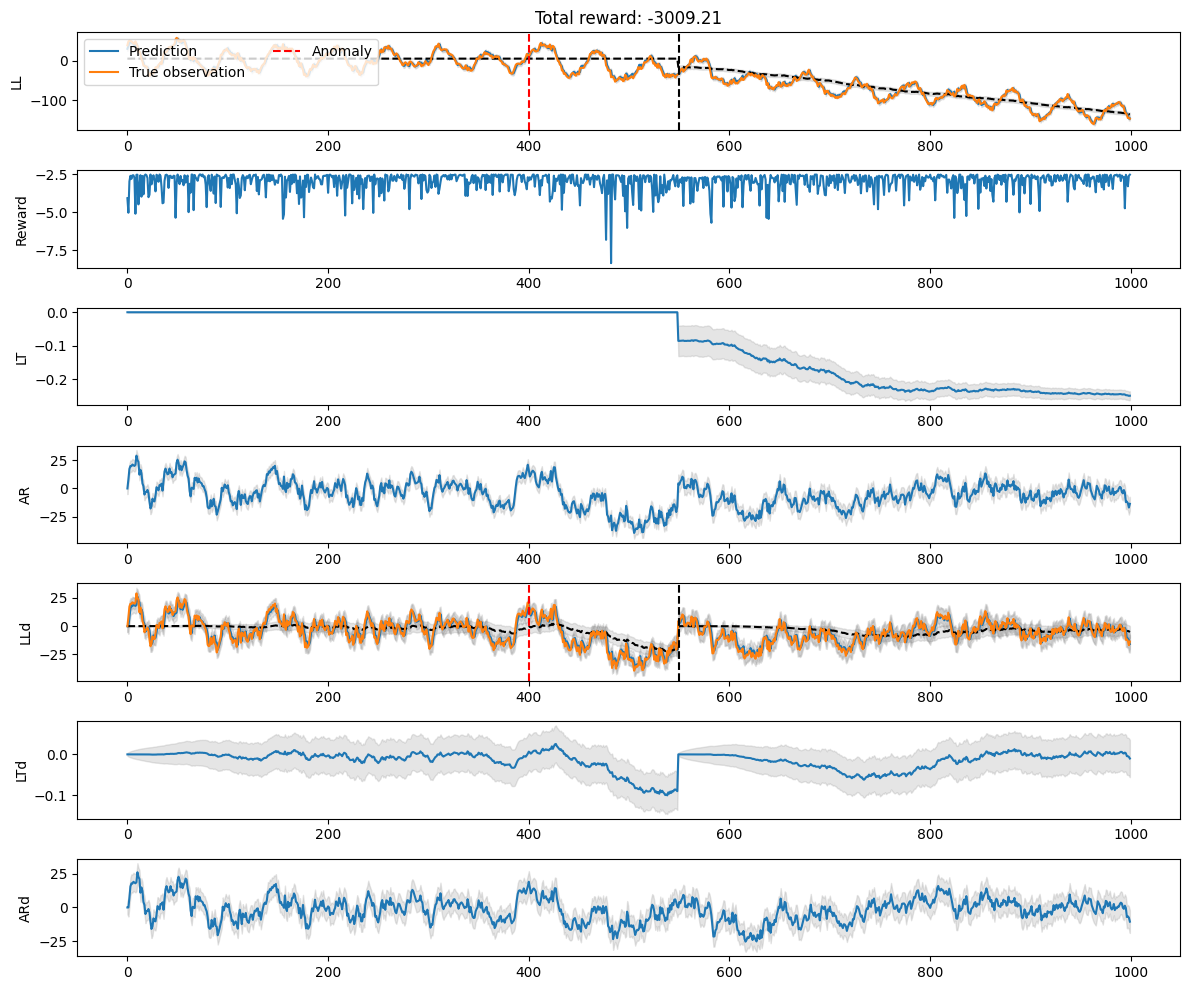

In [7]:
# Plot prediction
plt.rcParams["figure.autolayout"] = True
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(7, 1)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[2])
ax2 = plt.subplot(gs[3])
ax3 = plt.subplot(gs[4])
ax4 = plt.subplot(gs[5])
ax5 = plt.subplot(gs[6])
ax6 = plt.subplot(gs[1])

############ Base model ############
ax0.plot(data_generator.time_series['timesteps'], y_pred_mus, label='Prediction')
ax0.fill_between(data_generator.time_series['timesteps'], np.array(y_pred_mus)-np.sqrt(y_pred_vars), np.array(y_pred_mus)+np.sqrt(y_pred_vars),color='gray', alpha=0.2)
ax0.plot(data_generator.time_series['timesteps'], LL_mu, 'k--')
ax0.fill_between(data_generator.time_series['timesteps'], np.array(LL_mu)-np.sqrt(LL_var), np.array(LL_mu)+np.sqrt(LL_var),color='gray', alpha=0.2)
ax0.plot(data_generator.time_series['timesteps'], data_generator.time_series['y'], label='True observation')
if anm_mag != 0:
    ax0.axvline(x=anm_pos, color='r', linestyle='--', label='Anomaly')
if len(trigger_pos) > 0:
    for trigger in trigger_pos:
        ax0.axvline(x=trigger, color='k', linestyle='--')
ax0.legend(loc='upper left', ncol = 2)
ax0.set_ylabel('LL')
ax0.set_title('Total reward: {}'.format(np.round(np.sum(rewards), 2)))

# Plot rewards
ax6.plot(data_generator.time_series['timesteps'], rewards, label='Reward')
ax6.set_ylabel('Reward')

# Plot LT
ax1.plot(data_generator.time_series['timesteps'], LT_mu, label='LT prediction')
ax1.fill_between(data_generator.time_series['timesteps'], np.array(LT_mu)-np.sqrt(LT_var), np.array(LT_mu)+np.sqrt(LT_var),color='gray', alpha=0.2)
ax1.set_ylabel('LT')

# Plot AR
ax2.plot(data_generator.time_series['timesteps'], AR_mu, label='AR prediction')
ax2.fill_between(data_generator.time_series['timesteps'], np.array(AR_mu)-np.sqrt(AR_var), np.array(AR_mu)+np.sqrt(AR_var),color='gray', alpha=0.2)
ax2.set_ylabel('AR')

############ Meta-AR model ############
ax3.plot(data_generator.time_series['timesteps'], y_pred_mus_d, label='Prediction')
ax3.fill_between(data_generator.time_series['timesteps'], np.array(y_pred_mus_d)-np.sqrt(y_pred_vars_d), np.array(y_pred_mus_d)+np.sqrt(y_pred_vars_d),color='gray', alpha=0.2)
ax3.plot(data_generator.time_series['timesteps'], LLd_mu, 'k--', label='LL prediction')
ax3.fill_between(data_generator.time_series['timesteps'], np.array(LLd_mu)-np.sqrt(LLd_var), np.array(LLd_mu)+np.sqrt(LLd_var),color='gray', alpha=0.2)
ax3.plot(data_generator.time_series['timesteps'], AR_mu, label='AR')
ax3.fill_between(data_generator.time_series['timesteps'], np.array(AR_mu)-np.sqrt(AR_var), np.array(AR_mu)+np.sqrt(AR_var),color='gray', alpha=0.2)
if anm_mag != 0:
    ax3.axvline(x=anm_pos, color='r', linestyle='--', label='Anomaly')
if len(trigger_pos) > 0:
    for trigger in trigger_pos:
        ax3.axvline(x=trigger, color='k', linestyle='--')
ax3.set_ylabel('LLd')

# Plot LT
ax4.plot(data_generator.time_series['timesteps'], LTd_mu, label='LT prediction')
ax4.fill_between(data_generator.time_series['timesteps'], np.array(LTd_mu)-np.sqrt(LTd_var), np.array(LTd_mu)+np.sqrt(LTd_var),color='gray', alpha=0.2)
ax4.set_ylabel('LTd')

# Plot AR
ax5.plot(data_generator.time_series['timesteps'], ARd_mu, label='AR prediction')
ax5.fill_between(data_generator.time_series['timesteps'], np.array(ARd_mu)-np.sqrt(ARd_var), np.array(ARd_mu)+np.sqrt(ARd_var),color='gray', alpha=0.2)
ax5.set_ylabel('ARd')